In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import plot_confusion_matrix, f1_score, confusion_matrix

# Data

#### [US Used Cars Dataset](https://www.kaggle.com/datasets/ananaymital/us-used-cars-dataset?select=used_cars_data.csv)

This data set originally has:
- A whopping 66 variables
- 3,000,000 unique values

The 18 variables we have kept are: 
- body_type: Type String. Body Type of the vehicle. Like Convertible, Hatchback, Sedan, etc.
- latitude: Type Float. Latitude from the geolocation of the dealership.
- longitude: Type Float. Longitude from the geolocation of the dealership.
- daysonmarket: Type Integer. Days since the vehicle was first listed on the website.
- engine_displacement: Type Float. The measure of the cylinder volume swept by all of the pistons of a piston engine, excluding the combustion chambers.
- frame_damage: Type Boolean. Whether the vehicle has a damaged frame.
- fuel_type: Type String. Dominant type of fuel ingested by the vehicle.
- has_accidents: Type Boolean. Whether the vin has any accidents registered.
- horsepower: Type Float. Horsepower is the power produced by an engine.
- lisitng_color:  Type String. Dominant color group from the exterior color.
- major_options: list of strings of features.
- make_name: Type string. Manufacturer of car.
- mileage: Type float. Number of miles driven by car.
- model_name: Type string. 
- owner_count: Type float. Number of owners.
- price: Type float. Listed price of car.
- transmission: Type string. Type of transmission.
- wheel_system: Type string. Type of wheel_system.
- year: Type int. Year of manufacture.

For now, we will be trying to train with 'daysonmarket', 'engine_displacement', 
              'frame_damaged', 'has_accidents', 'horsepower',
              'major_options', 'mileage', 'owner_count', 'price', 'year'. In the Prelimary Results section, we will be using correlation metrics to see which variables are truly most appropriate.

In [ ]:
df = pd.concat([pd.read_csv("./datasets/d1.csv"), pd.read_csv("./datasets/d2.csv"), pd.read_csv("./datasets/d3.csv"), pd.read_csv("./datasets/d4.csv")])
print(df.shape)
df.head()

(1330246, 19)


,body_type,latitude,longitude,daysonmarket,engine_displacement,frame_damaged,fuel_type,has_accidents,horsepower,listing_color,major_options,make_name,mileage,model_name,owner_count,price,transmission,wheel_system,year
0,Coupe,18.3467,-66.1098,1252,1700.0,False,Gasoline,False,237.0,RED,['Leather Seats'],Alfa Romeo,301.0,4C,2.0,97579.0,A,RWD,2015
1,Sedan,18.3467,-66.1098,1233,3000.0,False,Gasoline,False,320.0,SILVER,"['Sunroof/Moonroof', 'Alloy Wheels', 'Bluetooth']",BMW,6903.0,3 Series,2.0,58995.0,A,AWD,2016
2,Sedan,40.7333,-73.2587,33,1600.0,False,Gasoline,False,201.0,BLACK,"['Sport Package', 'Sunroof/Moonroof', 'Adaptiv...",Hyundai,30707.0,Elantra,1.0,13324.0,A,FWD,2017
3,Sedan,40.7333,-73.2587,55,1500.0,False,Gasoline,False,160.0,SILVER,"['Driver Confidence Package', 'Power Package',...",Chevrolet,42394.0,Malibu,1.0,14639.0,A,FWD,2018
4,Coupe,40.8847,-73.8317,36,3500.0,False,Gasoline,False,311.0,BLACK,"['Leather Seats', 'Sunroof/Moonroof', 'Navigat...",Lexus,62251.0,RC 350,1.0,32000.0,A,AWD,2018


In [ ]:
#Create dataframe with variables we need
df_WIP = df.loc[:,['daysonmarket', 'engine_displacement', 'make_name', 
              'frame_damaged', 'has_accidents', 'horsepower',
              'major_options', 'mileage', 'owner_count', 'price', 'year']]
df_WIP = df_WIP.reset_index()
df_WIP = df_WIP.drop(['index'], axis = 1)

### One-hot Encoding

In [ ]:
#Turn major_options into one-hot encoded major options
mo = df_WIP['major_options']
mo = mo.str.replace("[","")
mo = mo.str.replace("]","")
mo = mo.str.replace("'","")
mo = mo.str.get_dummies(',')
df_WIP = pd.concat([df_WIP, mo], axis="columns")
df_WIP = df_WIP.drop(columns=['major_options'])
del mo


In [ ]:
#Turn make into one-hot encoded make
make = df_WIP['make_name']
make = make.str.get_dummies()
df_WIP = pd.concat([df_WIP, make], axis="columns")
df_WIP = df_WIP.drop(columns=['make_name'])
del make

Finalized data frame

In [ ]:
#convert True/False data into 1/0
df_WIP[['frame_damaged', 'has_accidents']] = df_WIP[['frame_damaged', 'has_accidents']].astype(int)
df_WIP.head()

,daysonmarket,engine_displacement,frame_damaged,has_accidents,horsepower,major_options,mileage,owner_count,price,year
0,1252,1700.0,0,0,237.0,1,301.0,2.0,97579.0,2015
1,1233,3000.0,0,0,320.0,3,6903.0,2.0,58995.0,2016
2,33,1600.0,0,0,201.0,12,30707.0,1.0,13324.0,2017
3,55,1500.0,0,0,160.0,14,42394.0,1.0,14639.0,2018
4,36,3500.0,0,0,311.0,7,62251.0,1.0,32000.0,2018


## Price Analysis and Categorization

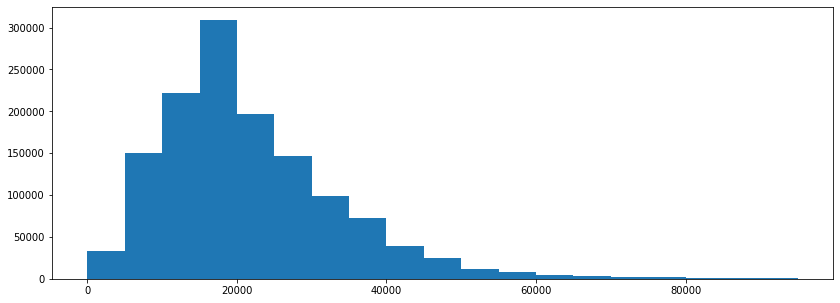

In [ ]:
df_pa = df_WIP['price']
plt.figure(figsize=(14, 5))
plt.hist(df_pa, bins=range(0, 100000, 5000))
plt.show()

Using $5000 as the width of bins, this histogram shows how many cars are in each price range.  
Most observations locate in the low price range, and the mode (or plurality) of the price is between $15000 - $20000. Perhaps this dataset will have a model preform better at predicting cheaper cars, rather than cars with a price higher than 60000. 

In [ ]:
pa_c, priceInterval = pd.qcut(x=df_pa, q=5, retbins=True)
del pa_c
priceInterval[0] = 0
for i in range(priceInterval.shape[0]):
    priceInterval[i] = int(round(priceInterval[i], -3))
priceInterval

array([      0.,    8000.,   11000.,   14000.,   16000.,   18000.,
         19000.,   22000.,   25000.,   28000.,   33000.,   40000.,
       3195000.])

This step is trying to convert a continuous value to multiple categories. To ensure each category has enough data to be trained and tested, the price range will not have a fixed size. We use Pandas.qcut to split the dataset into 5 price ranges, and round the boundary to thousands. Some range is too narrow or wide, hance we manually adjusted them. The next code block  and adds more ranges after $30k to make the classification more informative. After those stpes, we get 8 price ranges. Too many catergories make classification harder and slower. 

In [ ]:
priceInterval = priceInterval[0:-1].tolist()
priceInterval.extend([55000, 90000, 150000, 200000])

In [ ]:
price_count = pd.DataFrame({'lower bound':[], 'upper bound':[], 'count': []})
for i in range(len(priceInterval)):
    lower = priceInterval[i]
    if i < len(priceInterval) - 1:
        upper = priceInterval[i + 1]
        rowCount = df_pa.loc[(df_pa >= lower) & (df_pa < upper)].shape[0]
        price_count.loc[len(price_count.index)] = [lower, upper, rowCount]
    else:
        rowCount = df_pa.loc[(df_pa >= lower)].shape[0]
        price_count.loc[len(price_count.index)] = [lower, np.nan, rowCount]
        break

price_count

,lower bound,upper bound,count
0,0.0,8000.0,112322.0
1,8000.0,11000.0,106386.0
2,11000.0,14000.0,129798.0
3,14000.0,16000.0,115528.0
4,16000.0,18000.0,129450.0
5,18000.0,20000.0,120058.0
6,20000.0,22000.0,86261.0
7,22000.0,25000.0,110041.0
8,25000.0,28000.0,90715.0
9,28000.0,33000.0,117408.0


Here we count the number of rows in each price range. Since most ranges have more than 200k of data points, this price categorization is good enough for training and predicting. However, above $15k, there are only 1750 observations; it can be a problem when the model needs to predict the price for expensive cars. That is why we view them as outliers, and do not train or test on those data. 